In [1]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

### 讀入圖片

我們的目標圖片如下，有兩個癌細胞叢集。  
plt.imshow 要做色彩通道轉換才能正確顯示圖片顏色。（cv2: B → G → R 、matplotlib: R → G → B）

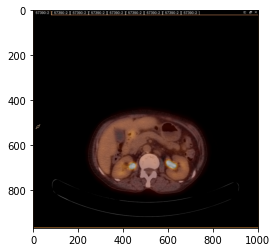

In [2]:
img = cv2.imread('I80.jpg', cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### 選取 ROI

我們使用手動選取 ROI 的方式（ cv2.selectROI ），選取的 ROI 會是一個矩形。

選完的 ROI 會是一個長度 4 的整數值組（ tuple ），長這樣： (x, y, width, height) 。  
其中 x 是 ROI 在原圖橫軸的最左側的點、y 是 ROI 在原圖縱軸的最上方的點、width 是 ROI 在原圖橫軸的大小、height 是 ROI 在原圖縱軸的大小。

cv2.imread 讀進來的圖片資料會被存成 numpy.ndarray ，我們可以利用陣列切片（ Indexing ）的技巧裁剪圖片。  
裁剪的小細節是 numpy.ndarray 的第一個維度是縱軸（ y ）、第二個維度是橫軸（ x ）。

註： cv2.destroyAllWindows 會關閉所有 OpenCV 開啟的視窗。有些系統（如我自架的 Linux）並不會在選完 ROI 之後自動關閉視窗，所以需要這一句

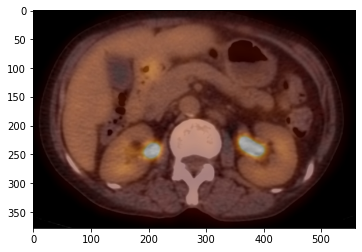

In [3]:
roi = cv2.selectROI(img)
cv2.destroyAllWindows()
crop = img[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))

### 過濾出癌細胞區域

整張圖片只有癌細胞所在區域（近乎純白）大量的藍色，我們利用這點抓出癌細胞。  

cv2.split 會將各顏色通道分開，它會回傳一個值組，內容為（B, G, R）三顏色的數值。所以我們在這裡選第 \[0\] 個就是圖片中的藍色部份。  
cv2.threshold 這句是請 OpenCV 把數值 145 作為一個分界，數值 145 以上的像素與數值 145 以下的像素分別做 cv2.THRESH_BINARY 這個動作。  
cv2.THRESH_BINARY 這個參數會讓 cv2.threshold 將分界以上的像素設定為 255 ；以下的設定為 0 。 

cv2.threshold 會回傳 tuple(你選取閾值, 處理好的圖片) ，我們只關心後者，所以取 \[1\] 。

把圖片製作成這樣是為了等一下要讓 cv2.findContours 查找邊界（它只接受這種僅有 0 或 255 的圖片）。

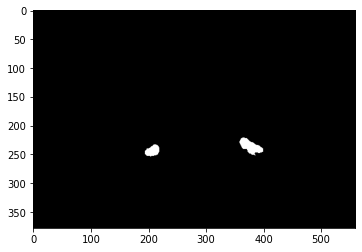

In [4]:
blueCrop = cv2.split(crop)[0]
thr145blue = cv2.threshold(blueCrop, 145, 255, cv2.THRESH_BINARY)[1]
plt.imshow(cv2.cvtColor(thr145blue, cv2.COLOR_BGR2RGB))

### 查找邊界

cv2.findContours 讓我們毫不費力的就能找出所有目標圖像的輪廓。  
cv2.RETR_EXTERNAL 參數表示只檢測外邊界、cv2.CHAIN_APPROX_NONE 儲存所有的輪廓點，相鄰的兩個點的像素位置差不超過 1 。

cv2.findContours 會回傳 tuple(包含所有輪廓的串列, 不同輪廓之間的索引標號) 。這個專案我不關心後者，所以我只取第一項 \[0\] 。

註：做完這步後就可以用 `cv2.drawContours(crop, contours, -1, (0, 255, 0), 3)` 繪製邊界了。不過我想標方框，所以還有以下步驟。

In [5]:
contours = cv2.findContours(thr145blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]

### 畫方框的事前準備

cv2.rectangle 可以幫我們在圖上畫方框，它需要我們給它方框的左上角座標及右下角座標。

以下的副程式會找出給定輪廓的左上角及右下角座標值。  

每一個輪廓點的集合都被紀錄在 shape 為 (n, 1, 2) 的 numpy.ndarray 裡面。  
其中第一個維度代表這個輪廓的第幾個點、第二個維度是點本身、第三個維度是輪廓點的 (橫軸座標值, 縱軸座標值) 。

In [6]:
def get_min_max_loc(points):
    y_min = points[:, 0, 0].min()
    y_max = points[:, 0, 0].max()
    x_min = points[:, 0, 1].min()
    x_max = points[:, 0, 1].max()

    return x_min, y_min, x_max, y_max

rects = [get_min_max_loc(c) for c in contours]

### 畫上方框

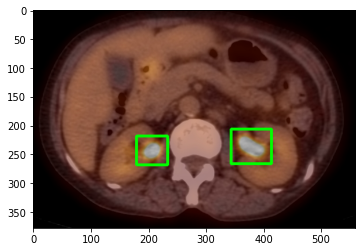

In [7]:
for rec in rects:
    cv2.rectangle(crop,
                  pt1=(rec[1] - 15, rec[0] - 15),  # 左上角 (y_min, x_min)
                  pt2=(rec[3] + 15, rec[2] + 15),  # 右下角 (y_max, x_max)
                  color=(0, 255, 0),
                  thickness=3)
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))